In [1]:
pip install numpy matplotlib gym stable-baselines3[extra] tqdm


  Using cached gym-0.26.2.tar.gz (721 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached stable_baselines3-2.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached gym_notices-0.1.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached gymnasium-1.2.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl.metadata (4.1 kB)
   ------

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install "shimmy>=2.0"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
#importing libraries 
# --- Cell 1: Imports ---
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize


In [121]:
# --- Cell 2: Define CarEnv ---
class CarEnv(gym.Env):
    """
    Simple car speed control environment.
    Action: acceleration in [-5, 5] m/s²
    Observation: [current_speed, error_to_setpoint]
    Reward: - (error^2)
    """

    def __init__(self):
        super(CarEnv, self).__init__()
        self.setpoint = 60.0  # target speed (km/h)
        self.dt = 0.1         # timestep (s)
        self.max_steps = 300

        # action: acceleration (m/s²)
        self.action_space = spaces.Box(low=-5.0, high=5.0, shape=(1,), dtype=np.float32)

        # observation: [speed, error]
        obs_low = np.array([0.0, -100.0], dtype=np.float32)
        obs_high = np.array([200.0, 100.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.reset()

    def step(self, action):
        accel = 5*float(action)
        disturbance = self.bump_force(self.step_count)
        self.v += accel * self.dt + disturbance
        self.v = max(0.0, self.v)
        error = self.setpoint - self.v
        reward = - (error ** 2) - 0.1 * (accel ** 2)
        if abs(error) < 2:
            reward += 10
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        truncated = False
        obs = np.array([self.v, error], dtype=np.float32)
        info = {}
        return obs, reward, terminated, truncated, info



    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.v = np.random.uniform(0, 10)  # initial speed
        self.step_count = 0
        error = self.setpoint - self.v
        obs = np.array([self.v, error], dtype=np.float32)
        info = {}
        return obs, info

    def bump_force(self, t):
        """Disturbance function f(t): random bumps every ~50 steps"""
        return 0 #np.random.uniform(-0.5, 0.5) if t % 50 == 0 and t > 0 else 0.0

In [122]:
# --- Cell 3: Training ---
# Create vectorized environment
env = make_vec_env(CarEnv, n_envs=1)

# Normalize obs & rewards
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Train PPO
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_car_tb/")
model.learn(total_timesteps=20000)

# Save model and normalization stats
model.save("ppo_car")
env.save("ppo_car_env.pkl")

env.close()


Using cpu device
Logging to ./ppo_car_tb/PPO_20


C:\Users\aadit\AppData\Local\Temp\ipykernel_9248\3827872593.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accel = 5*float(action)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -7.95e+05 |
| time/              |           |
|    fps             | 2398      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | -7.62e+05    |
| time/                   |              |
|    fps                  | 1634         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0088956375 |
|    clip_fraction        | 0.0668       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.201        |
|    

In [123]:
from stable_baselines3.common.vec_env import DummyVecEnv

raw_env = eval_env.envs[0].unwrapped

In [124]:
# --- Cell 4: Evaluation ---
# Recreate and load VecNormalize stats
eval_env = make_vec_env(CarEnv, n_envs=1)
eval_env = VecNormalize.load("ppo_car_env.pkl", eval_env)

# Turn off updates during eval
eval_env.training = False
eval_env.norm_reward = False

# Load trained model
model = PPO.load("ppo_car", eval_env)

# Run evaluation
obs = eval_env.reset()
speeds, times, bumps = [], [], []
t = 0
for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)

    # collect raw values (denormalized obs is inside eval_env)
    speeds.append(obs[0][0])   # first element is speed
    bumps.append(eval_env.envs[0].unwrapped.bump_force(t))  # unwrap to call custom method
    times.append(t)


    t += 1
    if done:
        obs = eval_env.reset()


C:\Users\aadit\AppData\Local\Temp\ipykernel_9248\3827872593.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accel = 5*float(action)


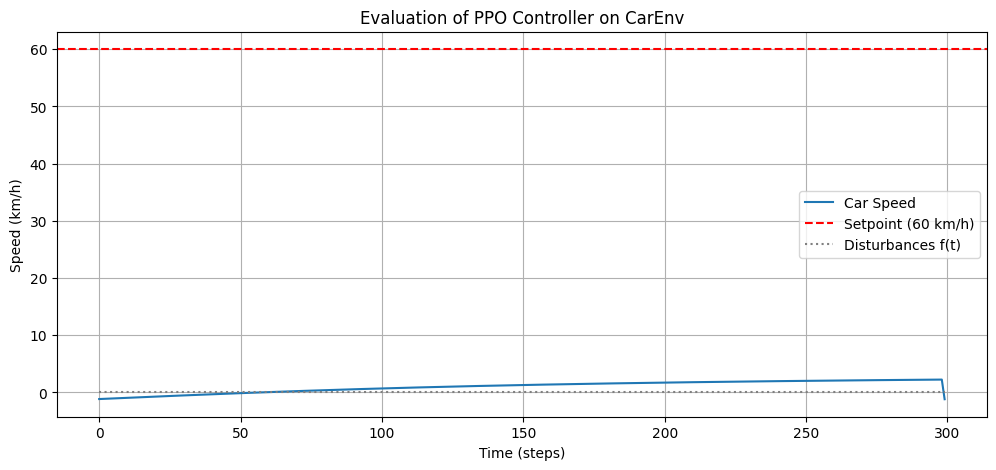

In [125]:
# --- Cell 5: Plot results ---
plt.figure(figsize=(12,5))
plt.plot(times, speeds, label="Car Speed")
plt.axhline(y=60, color="r", linestyle="--", label="Setpoint (60 km/h)")
plt.plot(times, bumps, color="gray", linestyle=":", label="Disturbances f(t)")

plt.xlabel("Time (steps)")
plt.ylabel("Speed (km/h)")
plt.title("Evaluation of PPO Controller on CarEnv")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXX

In [135]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CarEnv(gym.Env):
    """
    Simple car speed control environment with improved physics and reward.
    Action: acceleration in [-5, 5] m/s²
    Observation: [current_speed, error_to_setpoint]
    Reward: -(error^2) - small penalty on acceleration + bonus near setpoint
    """
    
    def __init__(self):
        super(CarEnv, self).__init__()
        self.setpoint = 60.0  # target speed (km/h)
        self.dt = 0.1         # timestep (s)
        self.max_steps = 500  # max steps per episode
        
        self.action_space = spaces.Box(low=-5.0, high=5.0, shape=(1,), dtype=np.float32)
        obs_low = np.array([0.0, -100.0], dtype=np.float32)
        obs_high = np.array([200.0, 100.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)
        
        self.reset()
        
    def step(self, action):
        accel = np.clip(float(action), -5.0, 5.0)
        drag_coeff = 0.01
        rolling_resistance = 0.005
        drag_force = drag_coeff * self.v ** 2
        rolling_force = rolling_resistance * self.v
        self.v += (accel - drag_force - rolling_force) * self.dt
        self.v = max(0.0, self.v)
        error = self.setpoint - self.v
        # Try a simpler reward
        reward = -abs(error) - 0.0001 * (accel**2)
        if abs(error) < 2.0:
            reward += 10
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        truncated = False
        obs = np.array([self.v, error], dtype=np.float32)
        info = {}
        return obs, reward, terminated, truncated, info

    
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.v = np.random.uniform(0, 10)
        self.step_count = 0
        error = self.setpoint - self.v
        obs = np.array([self.v, error], dtype=np.float32)
        info = {}
        return obs, info

In [136]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

# Use CarEnv directly
env = make_vec_env(CarEnv, n_envs=1)

env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0)

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_car_tb/",
            n_steps=128, batch_size=64, learning_rate=2.5e-4)

model.learn(total_timesteps=200_000)

model.save("ppo_car")
env.save("ppo_car_env.pkl")

env.close()

Using cpu device
Logging to ./ppo_car_tb/PPO_22
-----------------------------
| time/              |      |
|    fps             | 1999 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 128  |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1522         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0006924253 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0198       |
|    learning_rate        | 0.00025      |
|    loss                 | 3.05         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00091     |
|    std                  | 1            |
|    value_

C:\Users\aadit\AppData\Local\Temp\ipykernel_9248\751478718.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accel = np.clip(float(action), -5.0, 5.0)


------------------------------------------
| time/                   |              |
|    fps                  | 1354         |
|    iterations           | 3            |
|    time_elapsed         | 0            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0062136855 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.12        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0102       |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00359     |
|    std                  | 1.01         |
|    value_loss           | 0.136        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | -2.86e+04   |
| time/        

In [139]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

# Recreate evaluation environment and load normalization stats
eval_env = make_vec_env(CarEnv, n_envs=1)
eval_env = VecNormalize.load("ppo_car_env.pkl", eval_env)

# Make sure normalization stats are not updated during evaluation
eval_env.training = False
eval_env.norm_reward = False

# Load trained PPO model
model = PPO.load("ppo_car", eval_env)

# Reset environment to get initial observation
obs = eval_env.reset()
speeds = []
errors = []

for _ in range(500):  # run for 500 timesteps or as desired
    action, _states = model.predict(obs, deterministic=True)
    
    # Handle different gym step return signatures (4 or 5 elements)
    result = eval_env.step(action)
    if len(result) == 5:
        obs, reward, terminated, truncated, info = result
    else:  # fallback for older gym versions
        obs, reward, terminated, info = result
        truncated = False

    speeds.append(obs[0][0])  # current speed from observation
    errors.append(obs[0][1])  # error from observation

    if terminated or truncated:
        obs = eval_env.reset()

print("Evaluation complete.")

Evaluation complete.


C:\Users\aadit\AppData\Local\Temp\ipykernel_9248\751478718.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accel = np.clip(float(action), -5.0, 5.0)


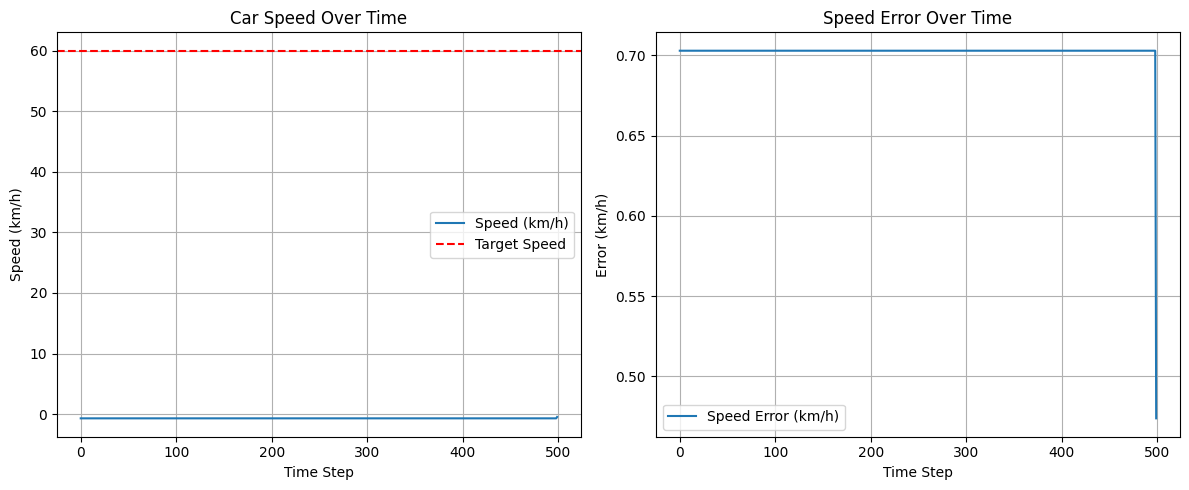

In [140]:
import matplotlib.pyplot as plt

def plot_speed_and_error(speeds, errors):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(speeds, label='Speed (km/h)')
    plt.axhline(y=60, color='r', linestyle='--', label='Target Speed')
    plt.title('Car Speed Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Speed (km/h)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(errors, label='Speed Error (km/h)')
    plt.title('Speed Error Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Error (km/h)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this function after evaluation
plot_speed_and_error(speeds, errors)